In [2]:
# %load cp_imports.py
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Use retina backend for better figures
%config InlineBackend.figure_format = 'retina'


# Particle Decay

Text(0,0.5,'Atom Quantity')

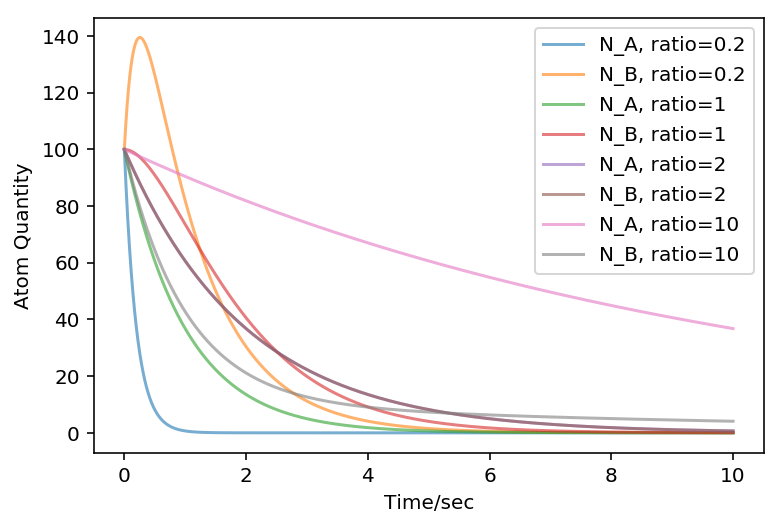

In [66]:
def multi_euler(t, df, f0, h, **kwargs):
    """
    1st order ODE solver with Euler method
    
    t: integration range, tuple
    df: derivative function of f
    f0: boundary condition 
    h: step 

    return function value of given t value
    """ 
    # t1 is the stop value of iteration
    t0, t1 = t
    sample_n = int((t1 - t0) / h)
    # Return a 2-D array 
    f = np.zeros((sample_n, len(f0)))
    f[0] = f0

    for i in range(1, sample_n):
        # Calculate next point with backward point
        f[i] = f[i-1] + df(f[i-1], **kwargs) * h
    return f


def decay_2atoms(xs, **kwargs):
    """
    xs: array of size 2
    xs[0]: NA
    xs[1]: NB
    
    """
    tau_a, tau_b = kwargs["tau_a"], kwargs["tau_b"]
    return np.array([-xs[0]/tau_a, xs[0]/tau_a - xs[1]/tau_b])
    
h = 1e-3
t1 = 10
t = np.arange(0, t1, h)
f0 = [100, 100]
# Set tau_b to 1, so change tau_a to obtain different ratio value
ratio = [0.2, 1, 2, 10] 
# Create list of lines for legend use
lines = []

ax = plt.gca()
for tau_a in ratio:
    f = multi_euler((0, t1), decay_2atoms, f0, h, tau_a=tau_a, tau_b=1)
    lines.extend(ax.plot(t, f, alpha=.6))
    lines[-2].set_label(f"N_A, ratio={tau_a}")
    lines[-1].set_label(f"N_B, ratio={tau_a}")

plt.legend()
plt.xlabel("Time/sec")
plt.ylabel("Atom Quantity");


For a 2-atom system, 
\begin{align}
    \frac{dN_A}{dt} &= - \frac{N_A}{\tau_A} \\
    \frac{dN_B}{dt} &= \frac{N_A}{\tau_A} - \frac{N_B}{\tau_B}
\end{align}
Write above equations in matrix form,
\begin{equation}
     \begin{bmatrix} 
               \frac{dN_A}{dt} \\
               \frac{dN_B}{dt} 
     \end{bmatrix} = %
     \begin{bmatrix}
        -\frac{1}{\tau_A}&  0\\
        \frac{1}{\tau_A}& - \frac{1}{\tau_B}
     \end{bmatrix} %
     \begin{bmatrix} 
               N_A \\
               N_B 
     \end{bmatrix}     
\end{equation}
Diagonalising above coefficient matrix, we can obtain the analytic
solution of this two-atom system. 
\begin{align}
    N_A &= \\
    N_B &= 
\end{align}

# Planet Orbit

## Newton mechanics

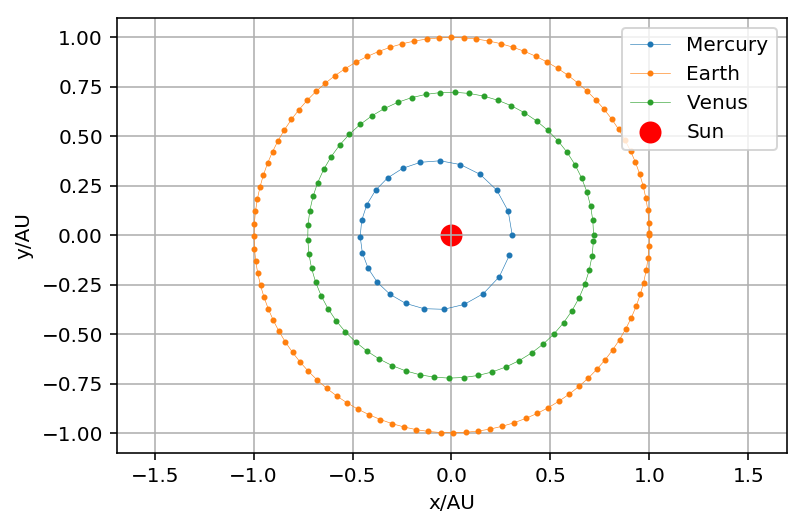

In [68]:
def rk4(t, df, f0, h, **kwargs):
    """
    Use RK4 method to solve ode
    
    t: tuple, start and stop values of variables
    df: derivative function of f, function of t and f
    f0: boundary condition for f
    h: step size of RK4
    
    """
    # t1 is the stop value of iteration
    t0, t1 = t
    sample_n = int((t1 - t0) / h)
    # Return a 2-D array 
    f = np.zeros((sample_n, len(f0)))
    f[0] = f0
    
    for i in range(1, sample_n):
        # In function df, separate independent variable and function f
        dx1 = df(t0, f0, **kwargs) * h
        dx2 = df(t0 + 0.5 * h, f0 + 0.5 * dx1, **kwargs) * h
        dx3 = df(t0 + 0.5 * h, f0 + 0.5 * dx2, **kwargs) * h
        dx4 = df(t0 + h, f0 + dx3, **kwargs) * h
        f0 += 1/6 * dx1 + 1/3 * dx2 + 1/3 * dx3 + 1/6 * dx4
        f[i] = f0
        t0 += h
        
    return f


def planet_newton(t, f):
    """
    EOM of planet in solar system with classical mechanic theory
    
    t: time Unit: yr
    f: motion parameters, x, vx, y, vy 
    
    return: the difference of f
    """
    # Unpack parameters for computation convenience
    x, vx, y, vy = f
    r = (x**2 + y**2)**0.5
    GM_sun = (2. * np.pi)**2
    return np.array([vx, -GM_sun * x / r**3, \
                     vy, -GM_sun * y / r**3])


h = 1e-2

planets = {"Mercury": [0.307, 0, 0, 12.43, 0.240846],
           "Earth": [1, 0, 0, 6.28, 1], 
           "Venus": [0.718, 0, 0, 7.43779, 0.615198]}
data = pd.DataFrame.from_dict(planets, orient='index')

# Plot planet orbits
for index, row in data.iterrows(): 
    f = rk4((0, 1.01*row[4]), planet_newton, row[:4], h)
    plt.plot(f[:, 0], f[:, 2], marker='o', markersize=2, label=index, linewidth=.3)
    
# Plot sun 
plt.scatter(0, 0, marker='o', color='red', s=100, label='Sun')

plt.axis("equal")
plt.grid(True)
plt.xlabel("x/AU")
plt.ylabel("y/AU")
plt.legend();


## General relativity modification

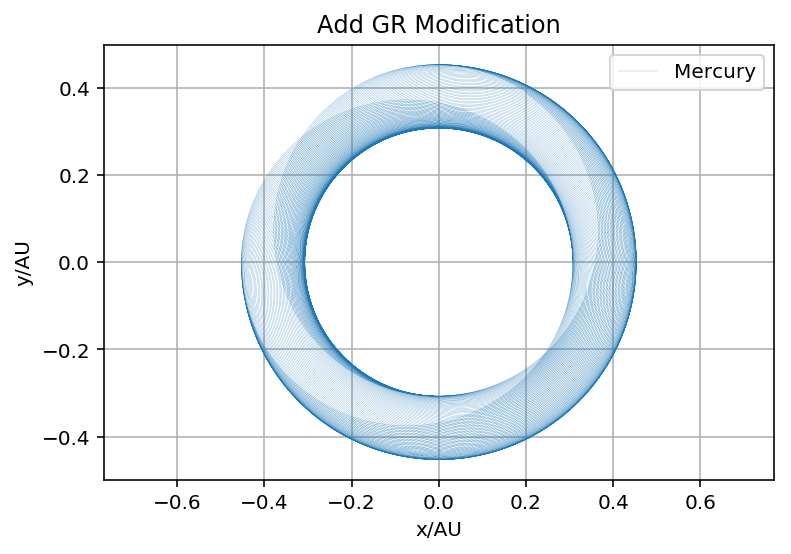

In [44]:
def planet_GR(t, f, beta=1e-3, **kwargs):
    """
    EOM of planet in solar system with GR modification
    
    t: time Unit: yr
    f: motion parameters, x, vx, y, vy Unit: AU/yr 
    beta: modification factor, typical value: 1.1x10^-8 AU^2 
    
    return: the difference of f
    """
    # Unpack parameters for computation convenience
    x, vx, y, vy = f
    r = (x**2 + y**2)**0.5
    GM_sun = (2. * np.pi)**2
    
    return np.array([vx, -GM_sun * x / r**3 * (1 + beta/r**2), \
                     vy, -GM_sun * y / r**3 * (1 + beta/r**2)])


mercury = [0.307, 0, 0, 12.43]
m_period = 0.240846 # Unit: yr
f = rk4((0, 100 * m_period), planet_GR, mercury, h)
plt.plot(f[:, 0], f[:, 2], marker='', markersize=2, label="Mercury", linewidth=.1)
plt.axis("equal")
plt.grid(True)
plt.xlabel("x/AU")
plt.ylabel("y/AU")
plt.title("Add GR Modification")
plt.legend();


# Three body problem

In [102]:
def rk45(t, df, f0, h, abserr=1e-5, relerr=1e-6, **args):
    """
    Use RK45 method to solve ode with adpative step size
    
    t: tuple, start and stop values of variables
    df: derivative function of f, function of t and f
    f0: boundary condition for f
    h: step size of RK4
    abserr: absolute error 
    relerr: relative error 
    
    """
    # t1 is the stop value of iteration
    t0, t1 = t
    sample_n = int((t1 - t0) / h)
    # Return a 2-D array 
    f = np.zeros((sample_n, len(f0)))
    f[0] = f0
    
    # Create coefficient arrays
    # Add 0 terms for sum convenience
    a = np.array([0, 1/5, 3/10, 3/5, 1, 7/8])
    b = np.array([[0, 0, 0, 0, 0, 0], 
                  [1/5, 0, 0, 0, 0, 0], 
                  [3/40, 9/40, 0, 0, 0, 0], 
                  [3/10, -9/10, 6/5, 0, 0, 0], 
                  [-11/54, 5/2, -70/27, 35/27, 0, 0], 
                  [1631/55296, 175/512, 575/13824, 44275/110592, 253/4096, 0]])
    # Transpose b and add newaxis for broadcast
    b = b.T[:, :, np.newaxis]
    c = np.array([37/378, 0, 250/621, 125/594, 0, 512/1771])
    d = np.array([2825/27648, 0, 18575/48384, 13525/55296, 277/14336, 1/4])
    
    # Create empty difference array for storing temp variables
    dfs = np.zeros((6, len(f0)))
    
    # Create loop variable i with initial value 1
    i = 1
    while i < sample_n:
        # In function df, separate independent variable and function f
        # Calculate dx1, dx2, ..., dx6, stored in a 6xN array
        for j in range(6):
            dfs[j] = h * df(t+a[j]*h, f0+np.sum(b[:,j,:]*dfs, axis=0))
        f4 = f0 + np.sum(d.T[:, np.newaxis] * dfs, axis=0)
        f5 = f0 + np.sum(c.T[:, np.newaxis] * dfs, axis=0)

        err_limit = abserr + relerr * max(abs(f0))
        err_current = max(abs(f4 - f5))
        # Adjust h according to current error
        if err_current > err_limit:
            # Loop until error is samller than limitation
            h = h * 0.9 *(err_limit/err_current)**(1/5)
        else: 
            # Error condition satisfied, continue iteration
            # Reset dfs to zero
            dfs.fill(0)
            f[i] = f5
            f0 = f5
            t0 += h
            h *= 1.5
            i += 1
            
    return f


def three_body_EOM(t, fs):
    """
    t: time, Unit: sec
    fs: state of motion, array of size 12
        for each object, need 4 parameters to describe its state
        x1, y1, vx1, vy1, x2, y2, vx2, vy2, x3, y3, vx3, vy3,
    
    """
    # Use global mass ratio m1, m2, m3
    r12 = ((fs[0] - fs[4])**2 + (fs[1] - fs[5])**2)**0.5  # Distance between 1 and 2
    r23 = ((fs[4] - fs[8])**2 + (fs[5] - fs[9])**2)**0.5
    r13 = ((fs[0] - fs[8])**2 + (fs[1] - fs[9])**2)**0.5
    f12_x = G * m1 * m2 * (fs[0] - fs[4]) / r12**3 # Force on 1 by 2, in x direction
    f12_y = G * m1 * m2 * (fs[1] - fs[5]) / r12**3
    f23_x = G * m2 * m3 * (fs[4] - fs[8]) / r23**3
    f23_y = G * m2 * m3 * (fs[5] - fs[9]) / r23**3
    f13_x = G * m1 * m3 * (fs[0] - fs[8]) / r13**3
    f13_y = G * m1 * m3 * (fs[1] - fs[9]) / r13**3
    # To get force on 2 by 1, just get negative f12
    return np.array([fs[2], fs[3], -(f12_x + f13_x)/m1, -(f12_y + f13_y)/m1,\
                     fs[6], fs[7], -(-f12_x + f23_x)/m2, -(-f12_y + f23_y)/m2,\
                     fs[10], fs[11], -(-f13_x - f23_x)/m3, -(-f13_y - f23_y)/m3])


h = 1e-2
G = 1.0
m1, m2, m3 = 3, 4, 5
# Initial position 
r1, r2, r3 = (4, 0), (0, 3), (0, 0)
f0 = np.array([*r1, 0, 0, *r2, 0, 0, *r3, 0, 0], dtype="float")

fs = rk45((0, 5), three_body_EOM, f0, h)


<IPython.core.display.Javascript object>


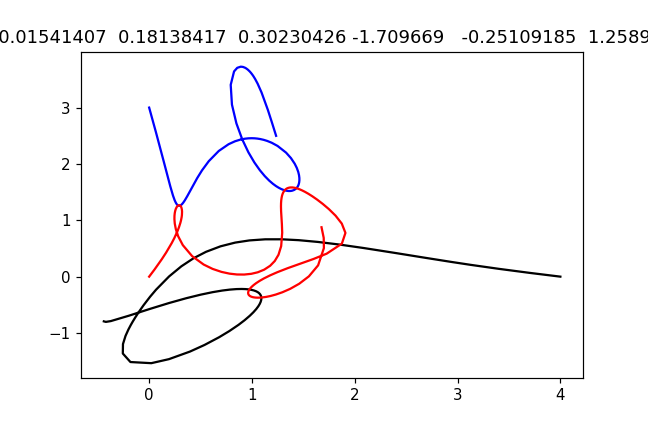

In [107]:
%matplotlib notebook
import matplotlib.animation as animation


def update(i):
    plt.clf()
    plt.plot(fs[:i, 0], fs[:i, 1], color='black', label='#1')
    plt.plot(fs[:i, 4], fs[:i, 5], color='blue', label='#2')
    plt.plot(fs[:i, 8], fs[:i, 9], color='red', label='#3')
    plt.title(f"v={fs[i, [2, 3, 6, 7, 10, 11]]}")
    return line


fig, ax = plt.subplots()
ax.set_xlim(-2, 5)
ax.set_ylim(-5, 5)
ani = animation.FuncAnimation(fig, update, frames=500, interval=100)
